# Forecasting Delays in the Swiss Transportation System

## Consistency Checks on Engineered Features with `fe_v1.py`

Copyrights © 2025, 2026 Yvan Richard.  
All rights reserved.

## Foreword

In this notebook, I rapidly check that the newly created features (with `fe_v1.py`) do not present major flaws.

## 1. Load Data

In [38]:
# load the data frame from january
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the data frame from january features
df_jan = pd.read_parquet("../../data/features/ist_features_2025_01.parquet")

# head
df_jan.head()

,op_date,trip_id,stop_id,stop_name,line_name,vehicle_type,additional_trip,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,...,vt_RJX,vt_S,vt_SN,vt_TER,vt_TGV,latitude,longitude,connection_density,running_trip_delay,mean_stop_delay
0,2025-01-03,ch:1:sjyid:100001:19215-001,8506013,Aadorf,S12,S,false,2025-01-03 05:28:00,2025-01-03 05:29:13,1.216667,...,False,True,False,False,False,47.488118,8.903301,35,1.355556,NaN
1,2025-01-03,ch:1:sjyid:100001:19220-001,8506013,Aadorf,S12,S,false,2025-01-03 05:31:00,2025-01-03 05:30:55,-0.083333,...,False,True,False,False,False,47.488118,8.903301,35,0.150000,1.216667
2,2025-01-03,ch:1:sjyid:100001:19219-002,8506013,Aadorf,S12,S,false,2025-01-03 06:28:00,2025-01-03 06:28:41,0.683333,...,False,True,False,False,False,47.488118,8.903301,35,0.577778,0.566667
3,2025-01-03,ch:1:sjyid:100001:19224-001,8506013,Aadorf,S12,S,false,2025-01-03 06:31:00,2025-01-03 06:31:04,0.066667,...,False,True,False,False,False,47.488118,8.903301,35,0.994444,0.605556
4,2025-01-03,ch:1:sjyid:100001:19223-002,8506013,Aadorf,S12,S,false,2025-01-03 07:28:00,2025-01-03 07:29:28,1.466667,...,False,True,False,False,False,47.488118,8.903301,35,2.272222,0.375000


## 2. Examine Data

Shape and structure of the data set:

In [39]:
# shape 
print(f" The shape of the dataset: {df_jan.shape}")

# info
df_jan.info()

 The shape of the dataset: (1796287, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796287 entries, 0 to 1796286
Data columns (total 37 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   op_date                datetime64[ns]
 1   trip_id                object        
 2   stop_id                int64         
 3   stop_name              object        
 4   line_name              object        
 5   vehicle_type           object        
 6   additional_trip        object        
 7   arrival_scheduled_dt   datetime64[ns]
 8   arrival_observed_dt    datetime64[ns]
 9   arrival_delay_minutes  float64       
 10  is_delayed             int8          
 11  hour_of_day            int32         
 12  day_of_week            int32         
 13  is_weekend             bool          
 14  is_peak                bool          
 15  vt_AG                  bool          
 16  vt_ATZ                 bool          
 17  vt_EC                  b

In [40]:
nulls = df_jan.isnull().sum()

nulls = nulls[nulls > 0]
print("Columns with null values:")
print(nulls)

Columns with null values:
latitude              26557
longitude             26557
running_trip_delay     7877
mean_stop_delay       19006
dtype: int64


As expected, I introduce some nan values in the data.

In [41]:
# print the stop_names with misisng geo coordinates
missing_geo = df_jan[df_jan['latitude'].isnull() | df_jan['longitude'].isnull()]['stop_name'].unique()
print("Stop names with missing geo coordinates:")
print(missing_geo)

Stop names with missing geo coordinates:
['Ausserberg' 'Biberbrugg' 'Biglen' 'Boltigen' 'Burghalden' 'Burgholz'
 'Chez-le-Maître-Ecoles' 'Colmegna' 'Därstetten' 'Eggerberg' 'Einsiedeln'
 'Enge im Simmental' 'Erlenbach im Simmental' 'Frutigen' 'Goppenstein'
 'Goppenstein Autoverlad' 'Grenchen Nord' 'Grosshöchstetten' 'Heimberg'
 'Hohtenn' 'Hurden' 'Häggenschwil-Winden' 'Im Holz' 'Interlaken Ost'
 'Interlaken West' 'Jestetten' 'Kandersteg' 'Langendorf' 'Le Brassus'
 'Le Lieu' "Le Sentier-L'Orient" 'Le Solliat-La Golisse'
 'Les Charbonnières' 'Les Esserts-de-Rive' 'Lommiswil' 'Lottstetten'
 'Lädeli' 'Maccagno' 'Muolen' 'Mülenen' 'Neukirch-Egnach' 'Oberdiessbach'
 'Oberdorf SO' 'Oberwil im Simmental' 'Oey-Diemtigen' 'Pino-Tronzano'
 'Reichenbach im Kandertal' 'Ringgenberg' 'Ringoldingen' 'Roggwil-Berg'
 'Samstagern' 'Schindellegi-Feusisberg' 'Spiez' 'Steffisburg'
 'Steinebrunn' 'Thun' 'Weissenburg' 'Wimmis' 'Wittenbach' 'Zweisimmen']


Before training my baseline models, I will need to impute those data.

### `running_trip_delay`, `mean_stop_delay`

Most of the features were constructed very straightforwardly but the last congestion features required more effort. I check those.

In [63]:
df_jan_1 = df_jan.copy()

trip_id = "ch:1:sjyid:100001:18457-001"
df_1 = df_jan_1[df_jan_1['trip_id'] == trip_id].sort_values(by=['arrival_scheduled_dt'])
df_1 = df_1[['stop_name', 'arrival_scheduled_dt', 'arrival_observed_dt', 'arrival_delay_minutes', 'running_trip_delay', 'mean_stop_delay']]
df_1.head(21)

,stop_name,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,running_trip_delay,mean_stop_delay
270776,Chêne-Bourg,2025-01-03 05:16:00,2025-01-03 05:15:53,-0.116667,NaN,7.777778e-02
506103,Genève-Eaux-Vives,2025-01-03 05:20:00,2025-01-03 05:19:52,-0.133333,-0.116667,-2.222222e-02
499448,Genève-Champel,2025-01-03 05:23:00,2025-01-03 05:23:23,0.383333,-0.125000,2.590520e-16
717253,Lancy-Bachet,2025-01-03 05:27:00,2025-01-03 05:27:28,0.466667,0.044444,-4.222222e-01
723909,Lancy-Pont-Rouge,2025-01-03 05:30:00,2025-01-03 05:30:41,0.683333,0.238889,1.041667e+00
483104,Genève,2025-01-03 05:36:00,2025-01-03 05:36:48,0.800000,0.511111,2.625000e-01
282712,Coppet,2025-01-03 05:47:00,2025-01-03 05:47:56,0.933333,0.650000,3.277778e-01
987759,Nyon,2025-01-03 05:54:00,2025-01-03 05:53:53,-0.116667,0.805556,5.566667e-01
529392,Gland,2025-01-03 05:58:00,2025-01-03 05:58:48,0.800000,0.538889,2.666667e-01
1180955,Rolle,2025-01-03 06:04:00,2025-01-03 06:04:14,0.233333,0.538889,-3.166667e-01


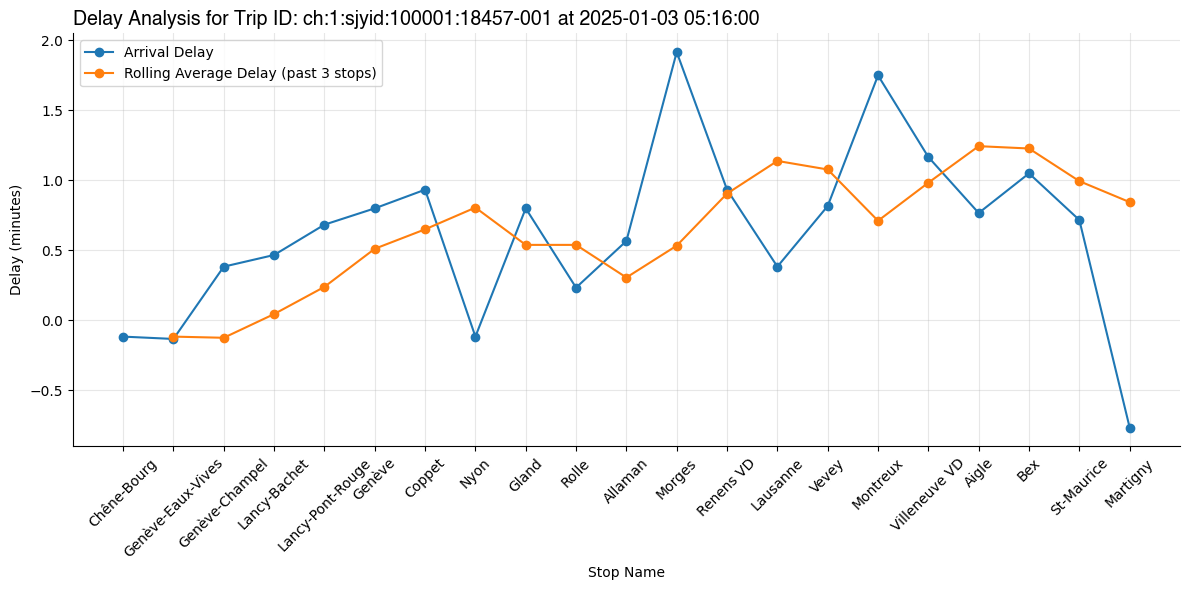

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

# subset data for the specific trip_id
df_sub = df_1[:21]
ax.plot(df_sub['stop_name'], df_sub['arrival_delay_minutes'], marker='o', label='Arrival Delay')
ax.plot(df_sub['stop_name'], df_sub['running_trip_delay'], marker='o', label='Rolling Average Delay (past 3 stops)')

ax.set_xlabel('Stop Name')
ax.set_ylabel('Delay (minutes)')
ax.set_title(f'Delay Analysis for Trip ID: {trip_id} at {df_sub["arrival_scheduled_dt"].iloc[0]}', loc = 'left', family='Helvetica', fontsize=14)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../../images/delay_analysis_{trip_id}.png', dpi=500)
plt.show()

Everything seems correct for the feature `running_trip_delay`. I now proceed with a sample test on `mean_stop_delay`:

In [66]:
df_jan_2 = df_jan.copy()
stop_name = "Zürich HB"
df_2 = df_jan_2[df_jan_2['stop_name'] == stop_name].sort_values(by=['arrival_scheduled_dt'])
df_2 = df_2[['arrival_scheduled_dt', 'arrival_observed_dt', 'arrival_delay_minutes', 'mean_stop_delay']]
df_2.head(21)

,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,mean_stop_delay
1657666,2025-01-01 00:42:00,2025-01-01 00:43:08,1.133333,NaN
1657667,2025-01-01 00:48:00,2025-01-01 00:48:29,0.483333,1.133333
1657668,2025-01-01 00:49:00,2025-01-01 00:49:30,0.500000,0.808333
1657669,2025-01-01 00:51:00,2025-01-01 00:52:46,1.766667,0.705556
1657670,2025-01-01 00:53:00,2025-01-01 00:55:43,2.716667,0.970833
1657671,2025-01-01 00:55:00,2025-01-01 00:57:36,2.600000,1.320000
1657672,2025-01-01 00:58:00,2025-01-01 01:01:03,3.050000,1.533333
1657673,2025-01-01 01:00:00,2025-01-01 01:00:18,0.300000,1.750000
1657674,2025-01-01 01:03:00,2025-01-01 01:03:11,0.183333,1.568750
1657675,2025-01-01 01:05:00,2025-01-01 01:05:53,0.883333,1.414815


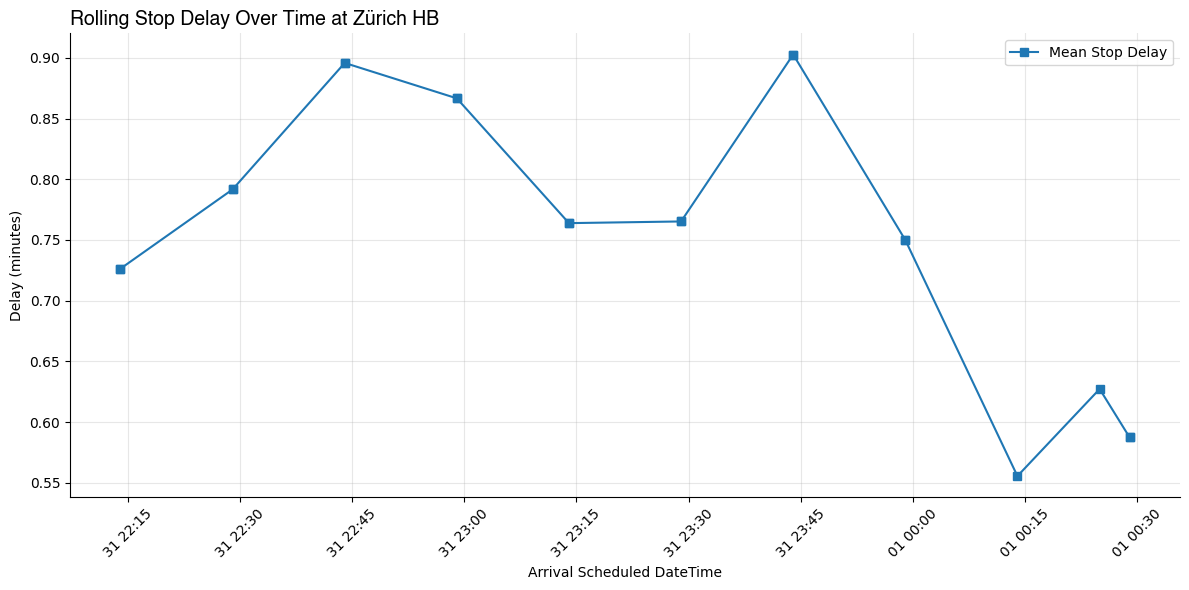

In [77]:
# subset of 200 entries for better visualization
sample = df_jan_2.tail(20)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(sample['arrival_scheduled_dt'], sample['mean_stop_delay'], marker = "s", label='Mean Stop Delay')

ax.set_xlabel('Arrival Scheduled DateTime')
ax.set_ylabel('Delay (minutes)')
ax.set_title(f'Rolling Stop Delay Over Time at {stop_name}', loc = 'left', family='Helvetica', fontsize=14)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(f'../../images/mean_stop_delay_{stop_name.replace(" ", "_")}.png', dpi=500)
plt.show()


Finally, I compute the summary statistics of those two columns:

In [79]:
# summary statistics of delay columns
delay_columns = ['arrival_delay_minutes', 'mean_stop_delay', 'running_trip_delay']
print(df_jan[delay_columns].describe())


       arrival_delay_minutes  mean_stop_delay  running_trip_delay
count           1.796287e+06     1.777281e+06        1.788410e+06
mean            7.874260e-01     7.752869e-01        7.856539e-01
std             2.017766e+00     9.190938e-01        1.745982e+00
min            -2.533000e+02    -5.573333e+01       -8.286111e+01
25%            -5.000000e-02     2.500000e-01        3.333333e-02
50%             5.000000e-01     6.444444e-01        4.833333e-01
75%             1.200000e+00     1.125000e+00        1.111111e+00
max             2.270167e+02     4.764167e+01        1.869944e+02


Nothing utterly wrong seems to stand out. This implies that the next step I should tackle are missing value imputation based on:

In [87]:
print("Missing Values Analysis\n-------------------------")
missings = pd.DataFrame(df_jan.isnull().sum())
missings = missings.rename(columns={0: 'missing_count'})
missings = missings[missings['missing_count'] > 0]
missings['missing_percentage'] = (missings['missing_count'] / len(df_jan)) * 100
missings.sort_values(by='missing_percentage', ascending=False)


Missing Values Analysis
-------------------------


,missing_count,missing_percentage
latitude,26557,1.478439
longitude,26557,1.478439
mean_stop_delay,19006,1.058071
running_trip_delay,7877,0.438516
